In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# !! need to insert this path to load h5py without errors!
#  (otherwise Python tries to load the h5py in default site-packages and throws an ImportError)
import sys
sys.path.insert(0, '/work2/08811/aew492/frontera/venv/illustris3.9/lib/python3.9/site-packages')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.cosmology import Planck15 as cosmo
import os
import illustris_python as il

sys.path.insert(0, '/work2/08811/aew492/frontera/small-scale_cross-corrs/code')
from xcorr_cases import HSC_Xcorr
from illustris_sim import TNGSim
import tools

#### target number densities

In [6]:
# instantiate object

# snapshots in each phot-z bin
snapshotss = [
    np.arange(59, 84), # center at z~0.45
    np.arange(47, 70), # center at z=0.75
    np.arange(40, 62),  # center at z=1.
    np.arange(35, 54)  # center at z=1.25
]

# the photo-z bins
photzbins = np.arange(0, 4)

# get the target number densities & the actual number densities from TNG in each phot-z bin
zs = []
target_ns_phot = []
sim_ns_phot = []
sim_ns_phot_stellar_mass = []
sim_ns_phot_SFR = []
sim_ns_phot_stellar_mass_SFR = []
target_ns_spec = []
for i, photzbin in enumerate(photzbins):
    print(f"photzbin {photzbin}:")
    X = HSC_Xcorr(snapshotss[i], photzbin, reference_survey='DESI', density_type='target')
    zs.append(X.redshifts)
    # target HSC densities from the survey
    target_ns_phot.append(X.ns_phot)
    # get the actual HSC density from TNG:
    # first with the defaults
    X.construct_photometric_galaxy_samples()
    sim_ns_phot.append(X.nhalos / (X.boxsize**3))
    # now with just the cut in stellar mass
    X.construct_photometric_galaxy_samples(discard_zero_stellar_mass=True)
    sim_ns_phot_stellar_mass.append(X.nhalos / (X.boxsize**3))
    # now with just the cut in SFR
    X.construct_photometric_galaxy_samples(discard_zero_SFR=True)
    sim_ns_phot_SFR.append(X.nhalos / (X.boxsize**3))
    # now with both
    X.construct_photometric_galaxy_samples(discard_zero_stellar_mass=True, discard_zero_SFR=True)
    sim_ns_phot_stellar_mass_SFR.append(X.nhalos / (X.boxsize**3))
    
    # and the spectroscopic (DESI) densities
    target_ns_spec.append(X.target_ns)
    print("")

photzbin 0:

photzbin 1:



photzbin 2:

photzbin 3:
warning! input redshift (1.6) outside DESI density table range (0.00-1.59)
warning! input redshift (1.67) outside DESI density table range (0.00-1.59)
warning! input redshift (1.74) outside DESI density table range (0.00-1.59)
warning! input redshift (1.82) outside DESI density table range (0.00-1.59)



Text(0.5, 1.0, 'HSC target number densities')

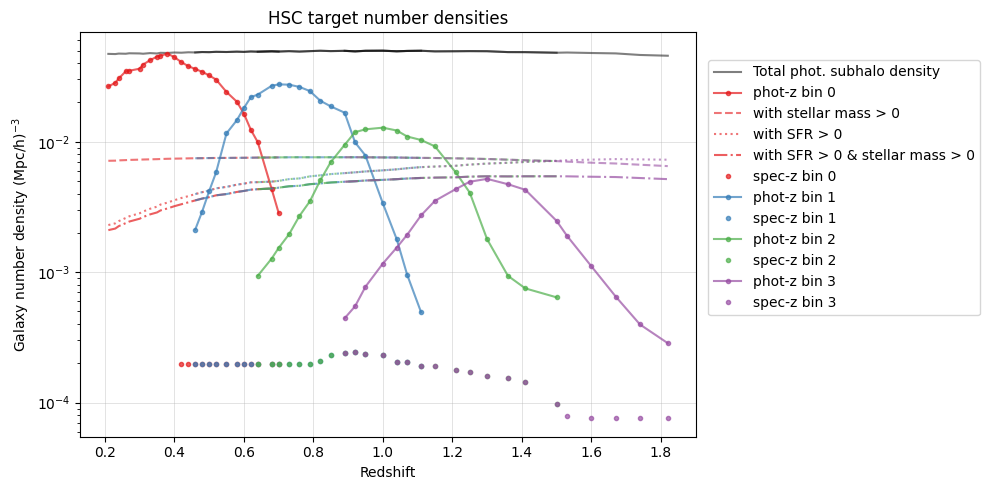

In [16]:
fig, ax = plt.subplots(figsize=(10,5), tight_layout=True)
cs = mpl.colormaps['Set1'].colors

for i, photzbin in enumerate(photzbins):
    label = 'Total phot. subhalo density' if i==0 else ''
    ax.plot(zs[i], sim_ns_phot[i], alpha=0.5, c='k', label=label)
    ax.plot(zs[i], target_ns_phot[i], marker='.', c=cs[i], alpha=0.7, label=f'phot-z bin {i}')
    label = 'with stellar mass > 0' if i == 0 else ''
    ax.plot(zs[i], sim_ns_phot_stellar_mass[i], alpha=0.6, c=cs[i], ls='--', label=label)
    label = 'with SFR > 0' if i == 0 else ''
    ax.plot(zs[i], sim_ns_phot_SFR[i], alpha=0.6, c=cs[i], ls=':', label=label)
    label = 'with SFR > 0 & stellar mass > 0' if i == 0 else ''
    ax.plot(zs[i], sim_ns_phot_stellar_mass_SFR[i], alpha=0.7, c=cs[i], ls='-.', label=label)
    ax.plot(zs[i], target_ns_spec[i], c=cs[i], marker='.', ls='None', alpha=0.7, label=f'spec-z bin {i}')

ax.grid(alpha=0.5, lw=0.5)
ax.axhline(0., c='k', alpha=0.5, lw=0.5)
ax.set_xlabel('Redshift')
ax.set_ylabel(r'Galaxy number density (Mpc/h)$^{-3}$')
ax.legend(loc=(1.02, 0.3))
ax.semilogy()
ax.set_title('HSC target number densities')

#### Cross-check galaxy numbers

what are the galaxy counts per phot-z bin calculated using the number densities from the redshift inference paper (Rau et al. 2023) and how do they compare to the raw galaxy numbers given for each bin by the cosmic shear results paper (Dalal et al. 2023)? (I don't expect these to be exactly the same, but I expect them to be close.)

In [6]:
total_gals_Dalal = [
    5889826,
    8445233,
    7023314,
    3902504
]  # in order of increasing redshift bin

In [7]:
for i, photzbin in enumerate(photzbins):
    X = HSC_Xcorr(snapshotss[i], photzbin)
    N = TNGSim(X.sim, snapshot=X.snapshots[0]).survey_params('HSC', zbin=X.photzbin).N
    diff = (N - total_gals_Dalal[i]) / total_gals_Dalal[i]
    print(f"bin {i}: {N} total galaxies ; {total_gals_Dalal[i]} from Dalal ({diff * 100:.2f}% difference)")

bin 0: 5659524 total galaxies ; 5889826 from Dalal (-3.91% difference)
bin 1: 7611084 total galaxies ; 8445233 from Dalal (-9.88% difference)
bin 2: 6004800 total galaxies ; 7023314 from Dalal (-14.50% difference)
warning! input redshift (1.6) outside DESI density table range (0.00-1.59)
warning! input redshift (1.67) outside DESI density table range (0.00-1.59)
warning! input redshift (1.74) outside DESI density table range (0.00-1.59)
warning! input redshift (1.82) outside DESI density table range (0.00-1.59)
bin 3: 3182544 total galaxies ; 3902504 from Dalal (-18.45% difference)


In [8]:
# okay these are at least correct to order of magnitude

#### how does my number density compare to the density used in simulations from Rau et al. (2022)?

Section 2, https://doi.org/10.1093/mnras/stab3290

*it's unclear to me if they're trying to simulate the observed number counts or use purposefully higher number counts.

*it ALSO sounds like they construct a LSST-like photometric sample, but whose number count slope is consistent with HSC deep field...

"Galaxies are assigned to the halo catalogue and supplemented with additional galaxies based on the assumption of a power law extrapolation of a power law sub-halo mass function at lower masses. The resulting catalogue exhibits a number count slope consistent with that of the Hyper SuprimeCam Deep survey (Aihara et al. 2018) down to an r-band magnitude of r ∼ 28, well beyond the apparent magnitudes that will be utilized in this paper... In this work we consider two data sets: an LSST-like photometric sample and a DESI-like spectroscopic sample that is used to investigate how much the inclusion of spatial cross-correlations constrains the sample redshift distributions."

In [9]:
N_gal = 2.26e9  # 2.26 billion
L = 4.255 << u.Gpc  # boxsize
n = N_gal / (L.to(u.Mpc)**3)
n /= (cosmo.h / cu.littleh)**3  # to get Mpc/h (multiplies by ~3 sin)

In [10]:
n

<Quantity 0.09437874 littleh3 / Mpc3>

In [11]:
# higher than the highest densities in my HSC sample!